In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import pickle

### Validation data load from PKL files

In [4]:
with open('./pkl_files/enchanced/validation/en_val_data.pkl', 'rb') as f:
    X_val = np.array(pickle.load(f))
with open('./pkl_files/enchanced/validation/en_val_data_age.pkl', 'rb') as f:
    y_val = np.array(pickle.load(f))
with open('./pkl_files/enchanced/validation/en_val_data_gender.pkl', 'rb') as f:
    gender_val = np.array(pickle.load(f))




### Training data load from PKL files

In [5]:
with open('./pkl_files/enchanced/training/en_train_data.pkl', 'rb') as f:
    X_train = np.array(pickle.load(f))
with open('./pkl_files/enchanced/training/en_train_data_age.pkl', 'rb') as f:
    y_train = np.array(pickle.load(f))
with open('./pkl_files/enchanced/training/en_train_data_gender.pkl', 'rb') as f:
    gender_train = np.array(pickle.load(f))

# images_arr_train = np.array(train_img_arr)
# bone_age_train = np.array(train_bone_age_arr)
# gender_train = np.array(train_gender_arr)

In [21]:
img_list = X_train

In [6]:
# X_train = images_arr_train
# X_val = images_arr_val
# y_train = bone_age_train
# y_val = bone_age_val
print("Training set: (",len(X_train),", ",len(y_train),")\n")
print("Validation set: (",len(X_val),", ",len(y_val),")\n")

Training set: ( 12611 ,  12611 )

Validation set: ( 1425 ,  1425 )


# Model Implementation Start

In [7]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from project_demo_2 import build_image_model
from keras.applications.inception_v3 import preprocess_input

import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply

In [8]:
Img_input = Input(shape= (299,299,3))
channel_axis = 3

In [9]:
# In inception v3 architecture, Every convolutin layer had batch normalization and relu activation function
from keras.layers import BatchNormalization
from keras.layers import Activation

def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1,1)):
    x=Conv2D(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x=BatchNormalization(axis=3, scale=False)(x)
    x=Activation('relu')(x)
    return x

In [10]:
from keras.layers import AveragePooling2D

def inc_block_a(x):
    branch1x1 = conv2d_bn(x,64,1,1)
    
    branch3x3 = conv2d_bn(x,48,1,1)
    branch3x3 = conv2d_bn(branch3x3,64,3,3)
    
    branch3x3db1 = conv2d_bn(x,64,1,1)
    branch3x3db1 = conv2d_bn(branch3x3db1,96,3,3)
    branch3x3db1 = conv2d_bn(branch3x3db1,96,3,3)
    
    branch_pool = AveragePooling2D((3,3), strides=(1,1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool,32,1,1)
    
    x = Concatenate(axis= channel_axis)([branch1x1,branch3x3,branch3x3db1,branch_pool])
    return x

In [11]:
def reduction_block_a(x):
    branch3x3 = conv2d_bn(x,384,3,3,strides=(2,2),padding='valid')
    
    branch3x3db1 = conv2d_bn(x,64,1,1)
    branch3x3db1 = conv2d_bn(branch3x3db1,96,3,3)
    branch3x3db1 = conv2d_bn(branch3x3db1, 96,3,3,strides=(2,2),padding='valid')
    
    branch_pool = MaxPooling2D((3,3),strides=(2,2))(x)
    
    x=Concatenate(axis=channel_axis)([branch3x3,branch3x3db1,branch_pool])
    
    return x

In [12]:
# 17 x 17 x 768

def inc_block_b(x):
    branch1x1 = conv2d_bn(x,192,1,1)
    
    branch7x7 = conv2d_bn(x,128,1,1)
    branch7x7 = conv2d_bn(branch7x7,128,1,7)
    branch7x7 = conv2d_bn(branch7x7,192,7,1)
    
    branch7x7db1 = conv2d_bn(x,128,1,1)
    branch7x7db1 = conv2d_bn(branch7x7db1,128,7,1)
    branch7x7db1 = conv2d_bn(branch7x7db1,128,1,7)  
    branch7x7db1 = conv2d_bn(branch7x7db1,128,7,1) 
    branch7x7db1 = conv2d_bn(branch7x7db1,192,1,7) 
    
    branch_pool = AveragePooling2D((3,3),strides=(1,1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool,192,1,1)
    
    x = Concatenate(axis = channel_axis)([branch1x1,branch7x7,branch7x7db1,branch_pool])
    
    return x

In [13]:
def reduction_block_b(x):
    branch3x3 = conv2d_bn(x,192,1,1)
    branch3x3 = conv2d_bn(branch3x3, 320,3,3,strides=(2,2),padding='valid')
    
    branch7x7x3 = conv2d_bn(x,192,1,1)
    branch7x7x3 = conv2d_bn(branch7x7x3,192,1,7)
    branch7x7x3 = conv2d_bn(branch7x7x3,192,7,1)
    branch7x7x3 = conv2d_bn(branch7x7x3,192,3,3,strides=(2,2),padding='valid')
    
    branch_pool = MaxPooling2D((3,3),strides=(2,2))(x)
    
    x = Concatenate( axis=channel_axis)([branch3x3,branch7x7x3,branch_pool])
    
    return x

In [14]:
from keras.layers import GlobalAveragePooling2D, AveragePooling2D
def inc_block_c(x):
    branch1x1 = conv2d_bn(x,320,1,1)
    
    branch3x3 = conv2d_bn(x,384,1,1)
    branch3x3_1 = conv2d_bn(branch3x3,384,1,3)
    branch3x3_2 = conv2d_bn(branch3x3,384,3,1)
    branch3x3 = Concatenate(axis=channel_axis)([branch3x3_1,branch3x3_2])
    
    branch3x3db1 = conv2d_bn(x,448,1,1)
    branch3x3db1 = conv2d_bn(branch3x3db1,384,3,3)
    branch3x3db1_1 = conv2d_bn(branch3x3db1,384,1,3)
    branch3x3db1_2 = conv2d_bn(branch3x3db1,384,3,1)
    branch3x3db1 = Concatenate(axis= channel_axis)([branch3x3db1_1,branch3x3db1_2])
    
    branch_pool = AveragePooling2D((3,3),strides=(1,1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool,192,1,1)
    
    x = Concatenate(axis=channel_axis)([branch1x1, branch3x3, branch3x3db1,branch_pool])
    
    return x

In [15]:
# Channel Attention Module
def channel_attention_module(x, ratio=8):
    
    batch,_,_,channel=x.shape
    # shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias= False)
    
    x1 = GlobalAveragePooling2D()(x)
    x1 = Flatten()(x1)
    x1 = l1(x1)
    x1 = l2(x1)
    
    x2 = GlobalMaxPooling2D()(x)
    x2 = Flatten()(x2)
    x2 = l1(x2)
    x2 = l2(x2)
    
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x,feats])
    
    return feats

In [16]:
# spatical attention module

def spatial_attention_module(x):
    # Average Pooling
    x1 = tf.reduce_mean(x,axis = -1)
    x1 = tf.expand_dims(x1,axis = -1)
    
    # max pooling
    x2 = tf.reduce_max(x, axis = -1)
    x2 = tf.expand_dims(x2,axis=-1)
    
    feats = Concatenate()([x1,x2])
    
    feats = Conv2D(1,kernel_size=7, padding="same",activation="sigmoid")(feats)
    feats = Multiply()([x,feats])
    
    return feats

In [17]:
# Cbam module
def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    
    return x

In [18]:
def inception_cbam_model(Img_input):
    x = conv2d_bn(Img_input, 32,3,3,strides=(2,2),padding='valid')
    x = conv2d_bn(x,32,3,3,padding='valid')
    x = conv2d_bn(x,64,3,3)
    x = MaxPooling2D((3,3), strides=(2,2))(x)

    x = conv2d_bn(x,80,1,1,padding='valid')
    x = conv2d_bn(x,192,3,3,padding='valid')
    x=MaxPooling2D((3,3),strides=(2,2))(x)

    x = inc_block_a(x)
    x = inc_block_a(x)
    x = inc_block_a(x)

    x = reduction_block_a(x)

    x = inc_block_b(x)
    x = inc_block_b(x)
    x = inc_block_b(x)
    x = inc_block_b(x)

    x = reduction_block_b(x)

    x = inc_block_c(x)
    x = inc_block_c(x)

    base_model = x
    #x = GlobalAveragePooling2D(name = 'avg_pool')(x)
    # x = Dense(1, activation ='softmax',name='predictions')(x)

    model = cbam(base_model)

    # Add additional layers 
    model = Flatten()(model)
    model = Dense(256, activation='relu')(model)
    model = Dropout(0.5)(model)
    prediction =  Dense(1, activation='sigmoid')(model)  # regression task for bone age
    # create model
    input = Img_input
    model = Model(inputs=input,outputs=prediction,name='inception_v3')
    return model


# Model Implementation End

# Demonstration

In [19]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

class RoiExtractor:
    def __init__(self):
        # Model initialization
        self.model = build_image_model()
        self.model.load_weights('./saved_weights/inception/best_final_5.h5')
        self.heatmap_model = Model(inputs=self.model.inputs, outputs=self.model.layers[-3].output)

        # Outputs
        self.heatmap_1 = None
        self.carpal_img = None

        self.heatmap_2 = None
        self.metacarpal_img = None

        self.img = None
        self.masked_img = None

    def generate_heatmap(self, img):

        # Preprocessing
        i = preprocess_input(img)
        preprocessed_img = np.expand_dims(i, axis=0)

        cbam_output = self.heatmap_model.predict(preprocessed_img)[0]

        #Heatmap generation
        heatmap = np.sum(cbam_output, axis=-1)
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
        upsampled_heatmap = cv2.resize(heatmap, (299, 299))
        return upsampled_heatmap


    def get_bounding_box(self, heatmap, threshold=0.7):
        binary_mask = (heatmap > threshold).astype(np.uint8)
        non_zero_indices = np.nonzero(binary_mask)
        if len(non_zero_indices[0]) == 0 or len(non_zero_indices[1]) == 0:
            return None
        min_row, min_col = np.min(non_zero_indices[0]), np.min(non_zero_indices[1])
        max_row, max_col = np.max(non_zero_indices[0]), np.max(non_zero_indices[1])

        bounding_box ={
            'min_row': min_row,
            'min_col': min_col,
            'max_row': max_row,
            'max_col': max_col
        }
        return bounding_box


    def crop_image_by_bounding_box(self, image, bounding_box):
        min_row, min_col = bounding_box['min_row'], bounding_box['min_col']
        max_row, max_col = bounding_box['max_row'], bounding_box['max_col']
        cropped_image = image[min_row:max_row + 1, min_col:max_col + 1, :]
        cropped_resized = cv2.resize(cropped_image, (224, 224))
        return cropped_resized


    def apply_black_rectangle_by_bounding_box(self, image, bounding_box):
        min_row, min_col = bounding_box['min_row'], bounding_box['min_col']
        max_row, max_col = 299, bounding_box['max_col']
        test_img = image.copy()
        test_img = cv2.rectangle(test_img, (min_col, min_row), (max_col, max_row), (0, 0, 0), thickness=cv2.FILLED)
        return test_img



    def process_img(self, img):
        self.img = img
        self.heatmap_1 = self.generate_heatmap(img)
        bounding_box_1 = self.get_bounding_box(self.heatmap_1)
        self.carpal_img = self.crop_image_by_bounding_box(img, bounding_box_1)
        bounding_box_1 = self.get_bounding_box(self.heatmap_1, 0.65)
        
        self.masked_img = self.apply_black_rectangle_by_bounding_box(img, bounding_box_1)
        self.heatmap_2 = self.generate_heatmap(self.masked_img)
        bounding_box_2 = self.get_bounding_box(self.heatmap_2, 0.6)
        self.metacarpal_img = self.crop_image_by_bounding_box(img, bounding_box_2)


    def save_cropped_img(self, metacarpal_path, carpal_path):
        cv2.imwrite(metacarpal_path, self.metacarpal_img)
        #cv2.imwrite(carpal_path, self.carpal_img)


    def show_heatmaps(self):
        fig, (ax1, ax2 )= plt.subplots(1,2)

        ax1.set_title('carpal')
        ax2.set_title('metacarpal')

        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax1.imshow(self.img)
        ax1.imshow(self.heatmap_1, cmap='jet', alpha=0.5)

        ax2.imshow(self.masked_img)
        ax2.imshow(self.heatmap_2, cmap='jet', alpha=0.5)
        plt.show()

    def show_cropped_images(self):
        fig, (ax1, ax2 )= plt.subplots(1,2)

        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax1.imshow(self.carpal_img)

        ax2.imshow(self.metacarpal_img)
        plt.show()

    def illustrate(self):
        self.show_heatmaps()
        self.show_cropped_images()




In [20]:
roi_extractor = RoiExtractor()

In [32]:
roi_extractor.process_img(img_list[100])

1/1 [==============================] - 0s 35ms/step


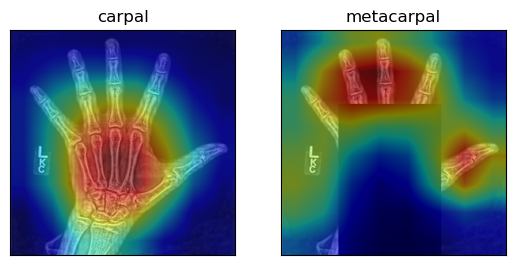

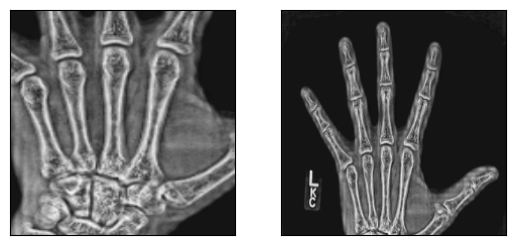

In [33]:
roi_extractor.illustrate()